# Report for Udacity Deep Reinforement Learning
# Project2: Continuous control

## Overview

This report is for the continuous control project at Deep Reinforcement Learning course by Udacity. The objective of the project is to train 20 copies of the same agent so that each agent with a double-jointed arm can maintain its position at the target location for as many time steps as possible. 
The agents must get an average score of +30 over 100 consecutive episodes, and over all agents.

## Learning Algorithm

[A2C](https://openai.com/blog/baselines-acktr-a2c/) is used, which is a synchronous variant of [A3C](https://arxiv.org/abs/1602.01783). Pseudocode of A3C from the cited paper is as follows.

<img src="files/content/a3c_suedocode.png" width="800"/> 

### Model

One neural network for policy $\pi(a|s;\theta')$ and value function $V(s;\theta'_v)$ is shared by all agents. The first and second hidden fully connected layers are shared by policy (actor) and value function (critic). In order to generate actions for continuous control, the network generates mean and standard deviation of Gaussian distribution, and actions are sampled from the distribution. Here is the corresponding code in [Continuous_Control.ipynb](./Continuous_Control.ipynb)


```python
    out1 = F.relu(self.fc1(state))
    out2 = F.relu(self.fc2(out1))

    # mean of the Gaussian distribution range in [-1, 1]
    mean = torch.tanh(self.fc_actor(out2))
    # V value
    value = self.fc_critic(out2)

    # Create distribution from mean and standard deviation
    # Use softplus function to make deviation always positive
    # SoftPlus is a smooth approximation to ReLU function
    dist = torch.distributions.Normal(mean, F.softplus(self.std))

    # Sample next action from the distribution.
    action = dist.sample()
    action = torch.clamp(action, min=-1.0, max=1.0)
```

#### Model structure

Model structure by torchviz library.
<img src="files/content/model.png" width="800"/> 

#### Model parameters
The following table shows model parameters. Linear-1 and Linear-2 is hidden layers, Linear-3 is for actions, and Linear-4 is for value function.
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Linear-1               [-1, 1, 128]           4,352
            Linear-2               [-1, 1, 128]          16,512
            Linear-3                 [-1, 1, 4]             516
            Linear-4                 [-1, 1, 1]             129
================================================================
Total params: 21,509
```


### Hyperparameters
The following hyperparameters are used.

| Parameter                       | Value         | Description                                                    |
|:--------------------------------|--------------:|:--------------------------------------------------------------|
| N-Step                          |             5 | Update model every n-step                                     |
| Discount factor \[$ \gamma $\]  |          0.99 | Discount factor used in Q-Learning                            |
| Critic_loss_coef                |           3.0 | Weight of critic loss                                         |
| Entropy_loss_coef               |         0.001 | Weight of entropy loss                                        |
| Learning rate \[$ \alpha $\]    |        0.0005 | Learning rate for Adam                                        |
| Standard deviation              |           1.0 | Initial standard deviation before SoftPlus is applied         |


## Results

### Plot of Rewards
At episode73, A2C achieved score 30.0.  
At episode 151, A2C achieved average score 30.0.  
Thus, the environment is considered solved.
![trained_result](files/content/trained_result.png)

### Trained agents' behavior

The following gif shows trained agent behaviors. This time, standard deviation for action generation is set to nearly zero, which means agents always take greedy actions. As the result, agents got an average score 38.85.
![trained_agent](files/results/track_l.gif)

## Consideration

1. Standard deviation

The following graph shows learning results with different initial standard deviations. Here, std as hyperparameter is chosen as 1.0 and 0.0. After softplus function is applied, actual std is 1.42 and 0.69 respectively. The following graph(a) shows that learning speed of bigger std is faster than smaller one. Also, it is observed that entropy gets bigger when std is not big enough(=0.69) to search action spaces, and entropy gets smaller when total loss starts to decrease below -2.0. Thus, for this environment, 1.0 is chosen as hyperparameter.

| ![total_loss_std]| ![entropy_std]|
|---|---|
|(a)Total Loss(Critic_loss_coef=1.0, Entropy_loss_coef=0.001)|(b)Entropy|

[entropy_std]:files/content/entropy_std.png
[total_loss_std]:files/content/total_loss_std.png

2. Weight of critic loss

The following graph shows results with different weights to critic loss. At first, the weight was set to 1.0, but  the value function became unstable after 75 episodes and the score was saturated to slightly lower than 30.0. In order to stabilize the value function which affects both actor and critic losses, a bigger weight 3.0 was selected. As a result, the environment was solved. One open point is that total loss has been rather increasing while the score is increasing, which means lower loss value does not directly mean better score.

|||
|---|---|
| ![total_loss-critic_weight] (a)Total loss| ![actor_loss-critic_weight] (b)Actor loss|
| ![critic_loss-critic_weight] (c)Critic loss without weight| ![entropy-critic_weight] (d)Entropy|
| ![score-critic_weight] (e)Score||

[total_loss-critic_weight]:files/content/total_loss-critic_weight.png
[actor_loss-critic_weight]:files/content/actor_loss-critic_weight.png
[critic_loss-critic_weight]:files/content/critic_loss-critic_weight.png
[entropy-critic_weight]:files/content/entropy-critic_weight.png
[score-critic_weight]:files/content/score-critic_weight.png


## Ideas for Future Work

For more stable results:
 * Add a small value to std to prevent log probability becomes infinity when std is zero.
 * Use gradient clipping when training to prevent too large change in an update.
 * Use Trust Region Policy Optimization (TRPO)
 * Try RMSprop instead of Adam
 * Try off-policy methods
 * Try separated network for actor and critic

## References
* [GitHub:ShangtongZhang/DeepRL](https://github.com/ShangtongZhang/DeepRL)
* [GitHub:qiaochen/A2C](https://github.com/qiaochen/A2C)
* [Let’s make an A3C: Implementation](https://jaromiru.com/2017/03/26/lets-make-an-a3c-implementation)
* [Understanding Actor Critic Methods and A2C](https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f)
* [ゼロから作る A3C](https://qiita.com/s05319ss/items/2fe9bfe562fea1707e79)

## Appendix
Code for graph of this report.

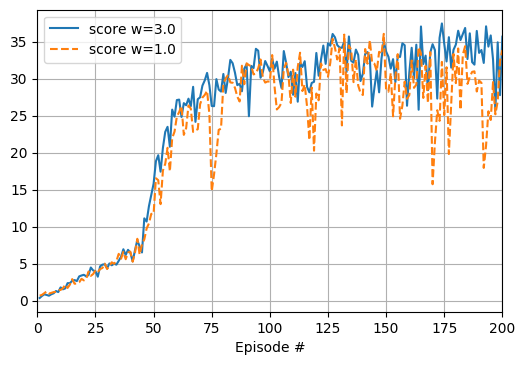

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
def plot(data_source):
    """Plot data
        Parameters
        ----------
            data_source : list
                [Data label, data file path, line type]  
    """
    plt.rcParams["figure.dpi"] = 100.0
    max_length = 200

    for source in data_source:
        data = np.loadtxt(source[1], skiprows=1, delimiter=', \t', dtype='float')
        length = len(data[:,])
        if length > max_length:
            length = max_length
            data = data[:length]
        
        # Comment/Uncomment to select data type
        plt.plot(np.linspace(1, length, length, endpoint=True), data[:,1], label="score " + source[0], ls = source[2])
        #plt.plot(np.linspace(1, length, length, endpoint=True), data[:,2], label="total_loss " + source[0], ls = source[2])
        #plt.plot(np.linspace(1, length, length, endpoint=True), data[:,3], label="actor_loss " + source[0], ls = source[2])
        #plt.plot(np.linspace(1, length, length, endpoint=True), data[:,4], label="critic_loss " + source[0], ls = source[2])
        #plt.plot(np.linspace(1, length, length, endpoint=True), data[:,5], label="entropy " + source[0], ls = source[2])
    
    plt.xlabel('Episode #')
    plt.legend()
    plt.xlim(0, length)
    plt.grid()
    plt.show()

data_paths = []

# Comment/Uncomment to select data source. Multiple data can be seleted.
data_paths.append(['w=3.0','results/critic3_en-3_std1.txt', "-"])
data_paths.append(['w=1.0','results/critic1_en-3_std1.txt', "--"])
#data_paths.append(['std=1.42','results/critic1_en-3_std1.txt', "-"])
#data_paths.append(['std=0.69','results/critic1_en-3_std0.txt', "--"])

plot(data_paths)